In [1]:
import sys
sys.path.append('../src')
sys.path.append('../EIrec_analysis/')
import numpy as np
from tqdm import tqdm
from scipy.special import erf, erfinv
from scipy.sparse import issparse
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
from helper_funcs import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, NI, N_HVC = 600, 150, 15

In [3]:
peak_rate, kernel_width = 150, 20

[Text(0, 0.5, 'auditory input neuron'), Text(0.5, 0, 'excitatory neuron')]

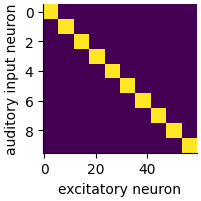

In [4]:
aud_mapping, s, m = 'neighbor', 3, None
# aud_mapping, s, m = 'gaussian', 3, None
# aud_mapping, s, m = 'discrete', 3, 1/100
aud_real, m = read_realistic_input('learned_song_responses.npz', NE, mean=0, scale=2,
                                   mapping=aud_mapping, mapping_args=m)
fig, ax = plt.subplots(1, figsize=(2,2))
ax.imshow(m[:10,:60], interpolation='none', aspect='auto')
ax.set(ylabel='auditory input neuron', xlabel='excitatory neuron')

In [5]:
print(aud_real['pert_t0'].min(), aud_real['pert_t1'].max())
PERT_T0, PERT_T1 = 160, 460

169.2290249433106 260.88435374149503


In [6]:
T_post = 200
T_song = aud_real['ctrl'].shape[2]
T_rend = T_song + T_post # Each rendition
N_rend = 35 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

In [7]:
aud, aud_idx = generate_realistic_aud(aud_real['ctrl'], N_rend, T_burn, T_post)

In [8]:
_ = np.arange(N_rend)
burst_ts = np.linspace(_*T_rend+T_burn, _*T_rend+T_burn+T_song, num=N_HVC, endpoint=False)
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
save_W_ts = np.round(burst_ts[-1]).astype(int)
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)
# for i in range(rH.shape[1]):
#     plt.plot(rH[:T_burn+T_rend,i], c='k', alpha=0.1+0.9*i/rH.shape[1])

In [9]:
r_rest = 2 # target rate when phi(0)
rmax, s = 50, 2
th = -erfinv(r_rest * 2 / rmax - 1) * (np.sqrt(2) * s)

In [10]:
tauE, tauI, dt = 30, 10, 1

In [11]:
rEmax, rImax, thE, thI, sE, sI = 100, 100, 0, 0, 2, 2

In [12]:
gen = lognormal_gen
# gen = const_gen
c = 0.5
srKEc, srKIc = np.sqrt(NE*c), np.sqrt(NI*c)
JEE0, JEI0, JIE0, JII0 = np.array([1/srKEc, 1.7/srKIc, 1/srKEc, 1.6/srKIc]) / 10
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.1
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=c<=0.5)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=c<=0.5)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=c<=0.5)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=c<=0.5)

In [13]:
w0_mean_HVC2E, w0_std_HVC2E, cW_HVC2E = 0.01/N_HVC, 1e-2, 1
w_inh_HVC2E = w0_mean_HVC2E*cW_HVC2E*0

netFF = WCNet(NE, N_HVC, w0_mean_HVC2E, (rmax, th, s), tauE, w_inh=w_inh_HVC2E, w0_std=w0_std_HVC2E)
netEI = EINet(NE, NI, N_HVC, w0_mean_HVC2E, (rEmax, thE+2, sE), (rImax, thI, sI), tauE, tauI, 
              JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
              w_inh=w_inh_HVC2E, w0_std=w0_std_HVC2E, cW=cW_HVC2E)

Not a recurrent model and rI will not be calculated.


100%|█████████████████████████████████████| 1499/1499 [00:00<00:00, 2462.44it/s]


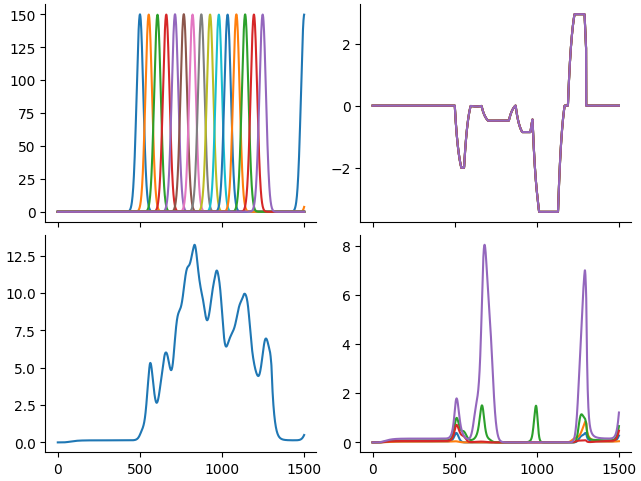

In [14]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
_ = netEI.sim(hE0, hI0, rH[:T_burn+T_rend], aud[:T_burn+T_rend], [], T_burn+T_rend, dt, 0)
rE_pre = _[0]
fig, ax = plt.subplots(2, 2, sharex='all')
ax[0,0].plot(rH[:T_burn+T_rend])
ax[0,1].plot(aud[:T_burn+T_rend,:5])
ax[1,1].plot(rE_pre[:T_burn+T_rend,:5]);
ax[1,0].plot(rE_pre[:T_burn+T_rend,:].mean(axis=1));

In [15]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
plasticity_kwargs = dict(plasticity=bilin_hebb_E_HVC, lr=-3e-2, 
                         tauW=1e5, asyn_H=0, rE_th=1)
_ = netFF.sim(hE0, rH, aud, save_W_ts, T, dt, 1, **plasticity_kwargs)
rE, rI, Ws_FF, _, _ = _
plasticity_kwargs = dict(plasticity=dict(HVC=bilin_hebb_E_HVC), lr=dict(HVC=-3e-1), 
                         tauW=1e5, asyn_H=0, rE_th=1)
_ = netEI.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 1, **plasticity_kwargs)
rE, rI, Ws_EI, _, _ = _
Ws_EI = Ws_EI['HVC']
if issparse(Ws_EI[0]):
    Ws_EI = [_.toarray() for _ in Ws_EI]

100%|███████████████████████████████████| 35499/35499 [00:10<00:00, 3246.71it/s]


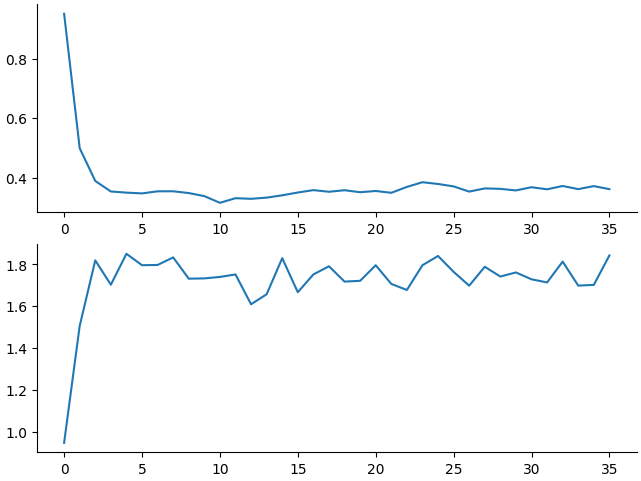

In [16]:
fig, ax = plt.subplots(2)
ax[0].plot([np.sqrt((_**2).sum()) for _ in Ws_FF])
ax[1].plot([np.sqrt((_**2).sum()) for _ in Ws_EI])

In [17]:
def plot_corr_mat(Ws, sortby=None, vmin=-1, vmax=1):
    corrs = [correlation(Ws[i].T, aud_real['ctrl'].mean(axis=0).T, dim=2) 
             for i in (0,-1)] \
          + [correlation(Ws[-1].T, aud_real['pert_strong'].mean(axis=0).T, dim=2)]
    if sortby == 'min':
        idx = np.argsort(np.nanargmin(corrs[1], axis=1))
    elif sortby == 'max':
        idx = np.argsort(np.nanargmax(corrs[1], axis=1))
    fig, ax = plt.subplots(1, 3, sharey='all', figsize=(6, 2))
    for i, j in enumerate(corrs):
        im = j if sortby is None else j[idx,:]
        im = ax[i].imshow(im, aspect='auto', interpolation='none', 
                          vmin=vmin, vmax=vmax, cmap='seismic')
    ax[0].set_title('Before learning, corr. with\ncorrect song')
    ax[1].set_title('\ncorrect song')
    ax[2].set_title('\nperturbed song')
    fig.text(0.45, 0.92, 'After learning, corr. with')
    cax = fig.colorbar(im, ax=ax, label='Correlation', ticks=[vmin, 0, vmax])
    return fig, ax

[Text(0, 0.5, 'HVC index'),
 Text(0.5, 0, 'Time (ms)')]

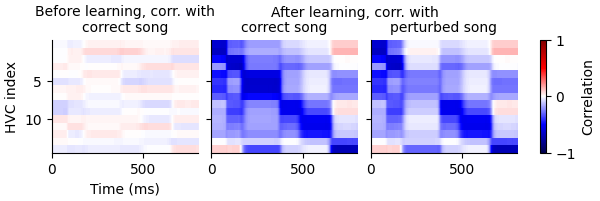

In [18]:
fig, ax = plot_corr_mat(Ws_FF)
ax[0].set(ylabel='HVC index', yticks=[5, 10], xlabel='Time (ms)')
# fig.savefig('../svg/supplementary/FF_learn_res.svg')

[Text(0, 0.5, 'HVC index'),
 Text(0.5, 0, 'Time (ms)')]

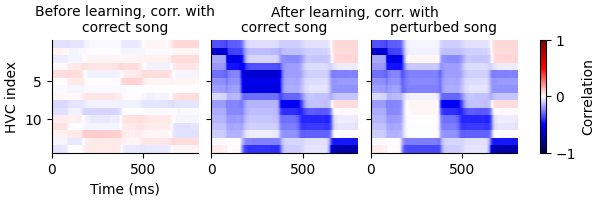

In [19]:
fig, ax = plot_corr_mat(Ws_EI)
ax[0].set(ylabel='HVC index', yticks=[5, 10], xlabel='Time (ms)')
# fig.savefig('../svg/supplementary/EI_learn_res.svg')

510


Text(0.5, 0, 'auditory input patterns of tutor song')

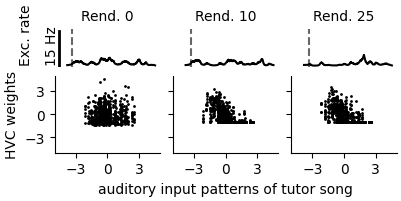

In [20]:
rends = (0, 10, 25)
_ = [rE[T_burn+j*T_rend:T_burn+(j+1)*T_rend-T_post].mean(axis=0) for j in rends]
k = rng.choice(np.where((_[0]>_[1]+0.1)&(_[1]>_[2]+0.1))[0])
print(k)
fig, ax = plt.subplots(2, 3, figsize=(4, 2), sharey='row', sharex='row', 
                       height_ratios=[1, 2])
for c, j in enumerate(rends):
    ax[0,c].plot(rE[T_burn+j*T_rend-50:T_burn+(j+1)*T_rend-T_post,k], color='k')
    ax[0,c].axvline(50, c='k', alpha=0.6, ls='--')
    ax[0,c].set_title('Rend. %d' % j, fontsize=10)
    ax[1,c].plot(normalize(aud_real['ctrl'][:,:,300:350].mean(axis=(0,2)), 0), 
                 normalize(Ws_EI[j][:,5], 0), '.', 
                 ms=2, color='k')
    ax[1,c].set(xlim=[-5, 5], ylim=[-5, 5], xticks=[-3, 0, 3])
    ax[0,c].set_axis_off()
ax[0,0].plot([-75, -75], [0, 15], c='k', lw=2)
ax[0,0].text(-150, 0, '15 Hz', va='bottom', ha='center', rotation=90)
ax[0,0].text(-400, 0, 'Exc. rate', va='bottom', ha='center', rotation=90)
# ax[0,0].legend(loc=(0, 1), title='Rendition #', ncols=3, frameon=False, 
#            handlelength=1, columnspacing=1)
ax[1,0].set(yticks=[-3, 0, 3], ylabel='HVC weights')
ax[1,1].set_xlabel('auditory input patterns of tutor song')
# fig.savefig('../svg/training_res.svg')

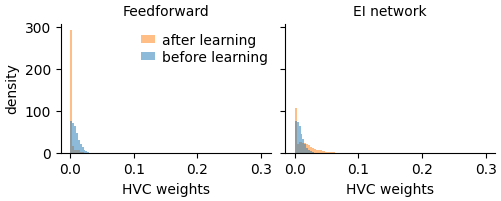

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2), sharey='all')
ax[0].hist([Ws_FF[0].flatten(), Ws_FF[-1].flatten()], density=True, bins=100, 
           range=(0, 0.3), histtype='stepfilled', alpha=0.5, 
           label=['before learning', 'after learning'])
ax[1].hist([Ws_EI[0].flatten(), Ws_EI[-1].flatten()], density=True, bins=100, 
           range=(0, 0.3), histtype='stepfilled', alpha=0.5)
ax[0].set(xlabel='HVC weights', ylabel='density', title='Feedforward')
ax[1].set(xlabel='HVC weights', title='EI network')
fig.legend(loc=(0.27, 0.65))

In [22]:
aud, aud_idx = generate_realistic_aud(aud_real['ctrl'], N_rend, T_burn, T_post)

In [23]:
w0_mean_E2E, w0_std_E2E, cW_E2E = 1/N_HVC, 0, 0.05
w_inh_E2E = w0_mean_E2E*cW_E2E*0

netEIrec = EINet(NE, NI, N_HVC, w0_mean_E2E, (rEmax, thE, sE), (rImax, thI, sI), tauE, tauI, 
                 JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                 w_inh=w_inh_E2E, w0_std=w0_std_E2E, cW=cW_E2E)

100%|█████████████████████████████████████| 1499/1499 [00:00<00:00, 4019.16it/s]


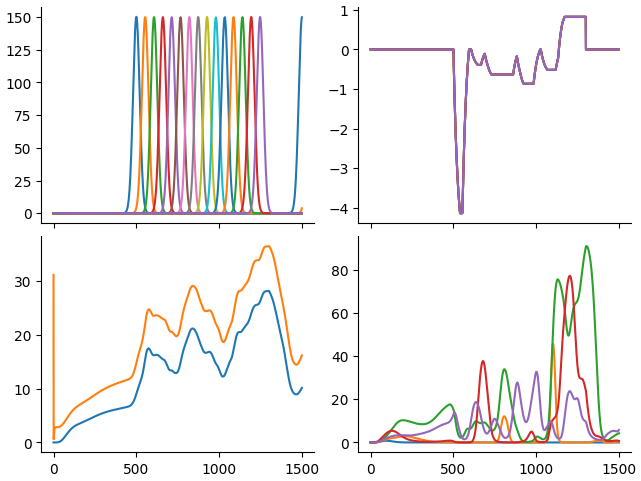

In [24]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
_ = netEIrec.sim(hE0, hI0, rH[:T_burn+T_rend], aud[:T_burn+T_rend], [], T_burn+T_rend, dt, 0)
rE_pre = _[0]
fig, ax = plt.subplots(2, 2, sharex='all')
ax[0,0].plot(rH[:T_burn+T_rend])
ax[0,1].plot(aud[:T_burn+T_rend,:5])
ax[1,1].plot(rE_pre[:T_burn+T_rend,:5]);
ax[1,0].plot(rE_pre[:T_burn+T_rend,:].mean(axis=1));
ax[1,0].plot(_[1].mean(axis=1))

100%|███████████████████████████████████████| 999/999 [00:00<00:00, 4035.39it/s]


[(0.0, 105.0), Text(0, 0.5, 'firing rate (Hz)')]

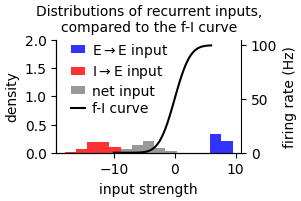

In [25]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
aux = [np.zeros_like(rH[:1000])+rH[:1000].mean(axis=1)[:,None], 
       np.zeros_like(aud[:1000])+aud[:1000].mean(axis=1)[:,None]]
_ = netEIrec.sim(hE0, hI0, *aux, [], 1000, dt, 0)
rE, rI, _, _, hE = _
ee_in = (netEIrec.JEE @ rE[:500].T).T.mean(axis=0)
ei_in = (netEIrec.JEI @ rI[:500].T).T.mean(axis=0)
_ = np.linspace(-10, 6)
fig, ax = plt.subplots(1, figsize=(3, 2))
ax = [ax, ax.twinx()]
ax[1].spines.right.set_visible(True)
ax[0].hist([ee_in-ei_in, -ei_in, ee_in], bins=15, density=True, 
           histtype='stepfilled', alpha=0.8, color=['grey', 'r', 'b'],
           label=[r'net input', r'I$\to$E input', r'E$\to$E input'])
ax[0].plot(0, 0, c='k', label='f-I curve')
ax[0].legend(loc=(0.05, 0.28))
ax[1].plot(_, EINet.phi(_, *netEIrec.phiE), color='k', zorder=10)
ax[0].set(ylabel='density', xlabel='input strength', ylim=[0, 2])
ax[0].set_title('Distributions of recurrent inputs,\ncompared to the f-I curve', fontsize=10)
ax[1].set(ylim=[0, 105], ylabel='firing rate (Hz)')
# fig.savefig('svg/show_EI_balance.svg', transparent=True)

In [26]:
# aux = netEIrec.W @ rH[:T_burn+T_rend].T - netEIrec.w_inh * rH[:T_burn+T_rend].sum(axis=1)[None,:]
# # plt.plot(aux[:50].T);
# plt.plot(aux.mean(axis=0))

In [27]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
# plasticity_kwargs = dict(plasticity=dict(JEE=bilin_hebb_EE), lr=dict(JEE=-5e-2),
#                          tauW=1e5, JEE0_mean=JEE0, asyn_E=10, rE_th=1.5)
# plasticity_kwargs = dict(plasticity=dict(JEI=bilin_hebb_EI), lr=dict(JEI=5e-2), tauW=1e5, 
#                          JEI0_mean=JEI0, asyn_I=10, rE_th=1.5)
plasticity_kwargs = dict(plasticity=dict(JEI=bilin_hebb_EI,JIE=bilin_hebb_IE), 
                         lr=dict(JEI=5e-2,JIE=5e-3), tauW=1e5, 
                         JEI0_mean=JEI0, JIE0_mean=JIE0, 
                         asyn_E=10, asyn_I=0, rE_th=1.5, rI_th=5)
_ = netEIrec.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 1, **plasticity_kwargs)
rE, rI, Ws, _, _ = _

100%|███████████████████████████████████| 35499/35499 [00:22<00:00, 1572.20it/s]


In [28]:
for k, v in Ws.items():
    if issparse(v[0]):
        Ws[k] = [_.toarray() for _ in v]
# Js = [get_J(netEIrec, JEE=wee) for wee in Ws['JEE']]
# Js = [get_J(netEIrec, JEI=wei) for wei in Ws['JEI']]
Js = [get_J(netEIrec, JEI=wei, JIE=wie) 
      for wei, wie in zip(Ws['JEI'], Ws['JIE'])]

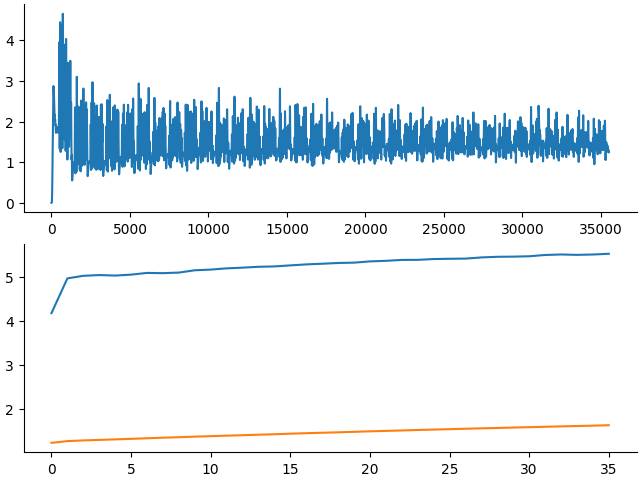

In [29]:
fig, ax = plt.subplots(2)
ax[0].plot(rE.mean(axis=-1))
# ax[1].plot([np.sqrt((_**2).sum()) for _ in Ws['JEE']])
ax[1].plot([np.sqrt((_**2).sum()) for _ in Ws['JEI']])
ax[1].plot([np.sqrt((_**2).sum()) for _ in Ws['JIE']])

[Text(0, 0.5, 'presyn. neuron index'), Text(0.5, 0, 'Time (ms)')]

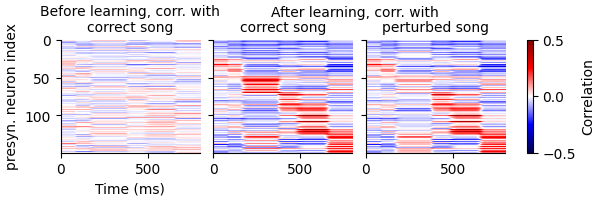

In [30]:
# fig, ax = plot_corr_mat(Ws['JEE'], sortby='min', vmin=-0.5, vmax=0.5)
fig, ax = plot_corr_mat(Ws['JEI'], sortby='max', vmin=-0.5, vmax=0.5)
ax[0].set(ylabel='presyn. neuron index', xlabel='Time (ms)')
# fig.savefig('../svg/supplementary/EIrec_learn_res.svg')

100%|█████████████████████████████████████| 1499/1499 [00:00<00:00, 3588.48it/s]
/home/zg93/Projects/Aiv-Network/realistic_auditory_processing/../src/utils.py:72: RuntimeWarning: invalid value encountered in divide
  sig2 = sig2.copy() / np.sqrt((sig2**2).sum(axis=-1, keepdims=True))


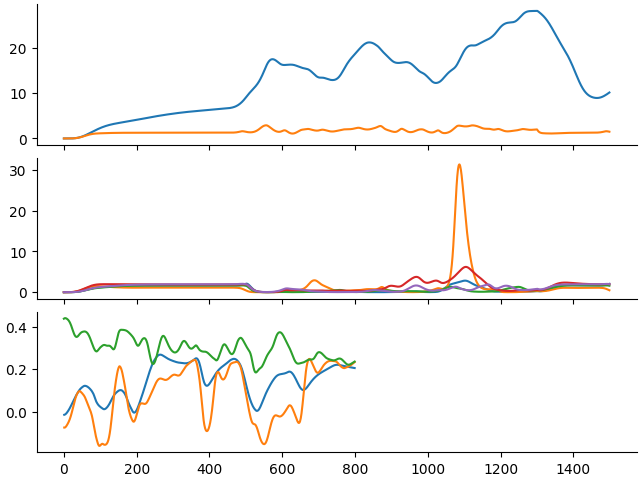

In [31]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
_ = netEIrec.sim(hE0, hI0, rH[:T_burn+T_rend], aud[:T_burn+T_rend,::1], [], T_burn+T_rend, dt, 0)
rE_post = _[0]
fig, ax = plt.subplots(3, sharex='all')
ax[0].plot(rE_pre[:T_burn+T_rend,:].mean(axis=1));
ax[0].plot(rE_post[:T_burn+T_rend,:].mean(axis=1));
# ax[1].plot(rE_pre[:T_burn+T_rend,:5]);
ax[1].plot(rE_post[:T_burn+T_rend,:5]);
pat_ctrl = aud_real['ctrl'][aud_idx].mean(axis=0).T
c_pre = correlation(rE_pre[-T_rend:-T_post,:NE], pat_ctrl, dim=1, cosine=True)
c_post = correlation(rE_post[-T_rend:-T_post,:NE], pat_ctrl, dim=1, cosine=True)
c = correlation(rE_pre[-T_rend:-T_post,:NE], rE_post[-T_rend:-T_post,:NE], dim=1, cosine=True)
ax[2].plot(c_pre)
ax[2].plot(c_post)
ax[2].plot(c)

## Testing

In [32]:
N_test_rend = 10
T_test = T_burn+T_rend
T_pre = 100 # time period to keep before song
args = (N_test_rend, T_burn, T_post, None, False)
aud_ctrl, aud_ctrl_idx = generate_realistic_aud(aud_real['ctrl'], *args)
aud_pert_weak, aud_pert_idx = generate_realistic_aud(aud_real['pert_weak'], *args)
aud_pert_strong, _ = generate_realistic_aud(aud_real['pert_strong'], *args)
cases = ('ctrl', 'pert_weak', 'pert_strong', 'deaf')

In [33]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
# 3 lists for 3 models
res = {k: [np.zeros((N_test_rend,T_pre+T_rend,NE+i)) for i in (0,NI,NI)] for k in cases} 
for k, a in zip(cases, (aud_ctrl, aud_pert_weak, aud_pert_strong, aud_ctrl*0)):
    for i in tqdm(range(a.shape[0])): # for each case, enumerate over songs
        args = dict(rH=rH[:T_test], aud=a[i], save_W_ts=[], T=T_test, dt=dt, 
                    noise_strength=1, no_progress_bar=True)
        res[k][0][i] = np.hstack(netFF.sim(hE0, **args)[:1])[T_burn-T_pre:]
        res[k][1][i] = np.hstack(netEI.sim(hE0, hI0, **args)[:2])[T_burn-T_pre:]
        res[k][2][i] = np.hstack(netEIrec.sim(hE0, hI0, **args)[:2])[T_burn-T_pre:]

100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.21it/s]


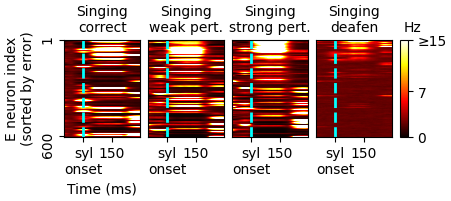

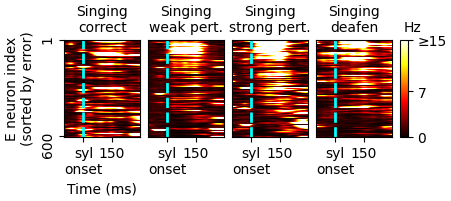

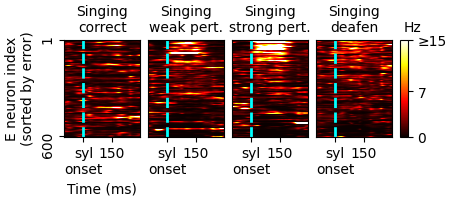

In [34]:
i = 0
titles = ['Singing\ncorrect', 'Singing\nweak pert.', 'Singing\nstrong pert.', 'Singing\ndeafen']
syl = aud_real['ctrl'][:,:,PERT_T0:PERT_T1].mean(axis=(0,2))
for l, m in enumerate(('FF', 'EI', 'EIrec')):
    _ = [res[k][l][i,:,:NE] for k in ('ctrl', 'pert_weak', 'pert_strong', 'deaf')]
    t0, t1 = int(aud_real['pert_t0'][i]) + T_pre, int(aud_real['pert_t1'][i]) + T_pre
    bos_ctrl = aud_real['ctrl'][i,:,t0:t1].mean(axis=1)
    bos_weak_pert = aud_real['pert_weak'][i,:,t0:t1].mean(axis=1)
    bos_strong_pert = aud_real['pert_strong'][i,:,t0:t1].mean(axis=1)
    err = [bos_ctrl - syl, bos_weak_pert - syl, bos_strong_pert - syl, -syl]
    fig, ax = plot_raster_cmp_syl_dsyl(_, titles, syl, err, t0, t1+250,
                                       figsize=(4.5, 2), plot_z=False, sort_by='e', th=15, tpre=100) 
    for j in range(len(ax)-1):
        ax[j].set(xticks=[100, 250], xticklabels=['syl\nonset', 150], xlabel='')
    ax[0].set(xlabel='Time (ms)')
    fig.savefig('../svg/err_response_%s_%s_map.svg' % (m, aud_mapping), transparent=True)

Text(0.5, 1.0, 'EI network\n(recurrent)')

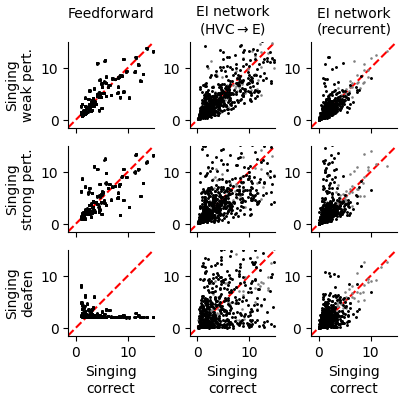

In [35]:
fig, ax = plt.subplots(3, 3, sharex='col', sharey='col', figsize=(4, 4))
# t0, t1 = T_pre + PERT_T0, T_pre + PERT_T1
t0, t1 = T_pre, T_pre + T_song
for i in range(3): 
    z_ctrl = res['ctrl'][i][:,t0:t1].mean(axis=(0,1))
    for j, k in enumerate(('pert_weak', 'pert_strong', 'deaf')):
        z_pert = res[k][i][:,t0:t1].mean(axis=(0,1))
        ax[j,i].scatter(z_ctrl[NE:], z_pert[NE:], s=3, c='grey')
        ax[j,i].scatter(z_ctrl[:NE], z_pert[:NE], s=5, c='k')
        ax[j,i].plot([-3, 20], [-3,20], c='r', ls='--', zorder=-1)
        ax[j,i].set(aspect=1, ylim=[-1.5,15], xlim=[-1.5,15], 
                    yticks=[0,10], xticks=[0,10])
        ax[-1,i].set(xlabel='Singing\ncorrect')
ax[0,0].set_ylabel('Singing\nweak pert.')
ax[1,0].set_ylabel('Singing\nstrong pert.')
ax[2,0].set_ylabel('Singing\ndeafen')
ax[0,0].set_title('Feedforward\n', fontsize=10)
ax[0,1].set_title('EI network\n(HVC$\\to$E)', fontsize=10)
ax[0,2].set_title('EI network\n(recurrent)', fontsize=10)
# fig.savefig('../svg/learn_real_joint_dist_%s_map.svg' % aud_mapping)

[np.float64(0.2296), np.float64(0.119), np.float64(0.0002), np.float64(0.0002)]
[np.float64(0.9998), np.float64(0.1692), np.float64(0.0006), np.float64(0.0004)]
[np.float64(0.0006), np.float64(0.0048), np.float64(0.0002), np.float64(0.0006)]


[[<matplotlib.axis.XTick at 0x7b31846cd390>,
 [Text(0, 0, 'Singing\ncorrect'),
  Text(1, 0, 'Singing\nweak pert.'),
  Text(2, 0, 'Singing\nstrong pert.'),
  Text(3, 0, 'Singing\ndeafen')],
 Text(0, 0.5, '% active')]

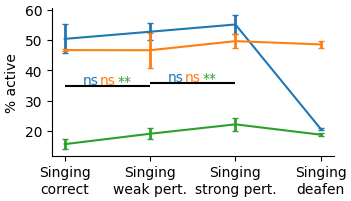

In [36]:
from scipy.stats import permutation_test
fig, ax = plt.subplots(1, figsize=(3.5, 2))
ax.hlines([35, 36], [0, 1], [1, 2], color='k')
def statistic(x, y):
    return x.mean() - y.mean()
for l, m in enumerate(('FF', 'EI', 'EIrec')):
    color = 'C%d' % l
    t0, t1 = T_pre, T_song+T_pre
    data = [(res[k][l][:,t0:t1,:NE].mean(axis=1)>3).mean(axis=1)*100
            for k in ('ctrl', 'pert_weak', 'pert_strong', 'deaf')]
    data = np.stack(data)
    ax.errorbar([0,1,2,3], data.mean(axis=1), yerr=data.std(axis=1), 
                capsize=2, elinewidth=2)
    pvs = [permutation_test(data[0:2], statistic).pvalue, 
           permutation_test(data[1:3], statistic).pvalue,
           permutation_test([data[0],data[3]], statistic).pvalue,
           permutation_test([data[0],data[3]], statistic).pvalue]
    print(pvs)
    for i, pv in enumerate(pvs[:-2]):
        if pv * 2 < 0.05:
            ax.text(i+0.5+(l-1)*0.2, 35+i if i<2 else 34, 
                    '*' if pv * 2 > 0.01 else '**', ha='center', c='C%d'%l)
        else:
            ax.text(i+0.5+(l-1)*0.2, 35.5+i if i<2 else 34.5, 
                    'ns', ha='center', c='C%d'%l)
ax.set(xticks=[0,1,2,3], xticklabels=titles, ylabel='% active')

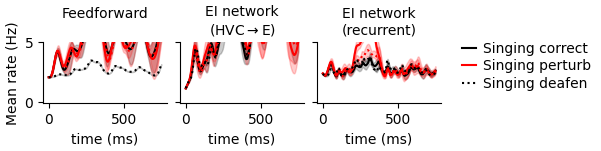

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(6,1.5), sharey='all')
for i, k in enumerate(('Feedforward\n', 'EI network\n(HVC$\\to$E)', 
                       'EI network\n(recurrent)')):
    for j, c in zip(('ctrl', 'pert_weak', 'pert_strong', 'deaf'), ('k', 'r', 'r', 'k')):
        aux = res[j][i][:,T_pre:-T_post-50].mean(axis=-1)
        plot_mean_std(ax[i], aux.mean(axis=0), aux.std(axis=0), 0.2, c, 
                      ls='-' if j in ('ctrl', 'pert_strong') else ':')
        ax[i].hlines(7, aud_real['pert_t0'].mean()-aud_real['pert_t0'].std(), 
                        aud_real['pert_t1'].mean()+aud_real['pert_t1'].std(),
                     lw=3, color='m')
    ax[i].set(xlabel='time (ms)', title=k)
ax[0].set_ylabel('Mean rate (Hz)')
ax[-1].set_axis_off() # dummy
for k, c in zip(('correct', 'perturb', 'deafen'), ('k', 'r', 'k')):
    ax[-1].plot(0,0, c=c, ls='-' if k!='deafen' else ':', label='Singing '+k)
ax[-1].set_ylim([-0.1, 5])
ax[-1].legend()
# fig.savefig('../svg/learn_real_mean_rates.svg')

In [38]:
from scipy.linalg import svd

svds = [svd(J) for J in Js]

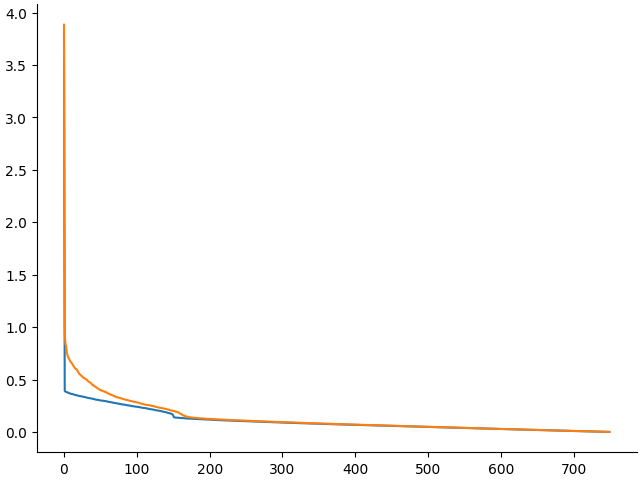

In [39]:
plt.plot(svds[0][1])
plt.plot(svds[-1][1])

In [40]:
def characterize_change(svds, left=True, first_n=100, th_quantile=0.95):
    if left:
        pwsim_sv = [svds[0][0].T @ sv[0][:,:first_n] for sv in svds]
    else:
        pwsim_sv = [svds[0][2] @ sv[2][:first_n].T for sv in svds]
    pwsim_sv = np.stack(pwsim_sv, 0) # (Epoch, N, first_n)
    change = 1 - np.abs(pwsim_sv).max(axis=1)
    
    # identify landscape modes
    th_land = np.quantile(change[-1], th_quantile)
    i_landscape = np.where(change[-5:].mean(axis=0) > th_land)[0]
    i_nonland = [i for i in range(change.shape[1]) if i not in i_landscape]

    return change, i_landscape, i_nonland
    
def characterize_memory(svds, song, left=True, th_quantile=1):
    NE = song.shape[-1]
    if left:
        corr_song = [correlation(sv[0][:NE].T, song, dim=2, cosine=True) for sv in svds]
    else:
        corr_song = [correlation(sv[2][:,:NE], song, dim=2, cosine=True) for sv in svds]
    corr_song = np.stack(corr_song, 0) # (Epoch, N, N_patterns)
    memory_encode = np.abs(corr_song).max(axis=-1)

    # identify memory modes
    th_mem = np.quantile(memory_encode[0], th_quantile)
    i_memory = np.where(memory_encode[-5:].mean(axis=0) > th_mem)[0]
    i_nonmem = [i for i in range(memory_encode.shape[1]) if i not in i_memory]

    return memory_encode, i_memory, i_nonmem

In [41]:
from scipy.signal import find_peaks
syl = aud_real['ctrl'].mean(axis=0).T # take mean
syl = syl[find_peaks(np.abs(syl).mean(axis=1))[0]]

In [42]:
l_change, il_landscape, il_nonland = characterize_change(svds, left=True, first_n=100, th_quantile=0.95)
l_mem_enc, il_memory, il_nonmem = characterize_memory(svds, syl, left=True, th_quantile=1)
r_change, ir_landscape, ir_nonland = characterize_change(svds, left=False, first_n=100, th_quantile=0.95)
r_mem_enc, ir_memory, ir_nonmem = characterize_memory(svds, syl, left=False, th_quantile=1)

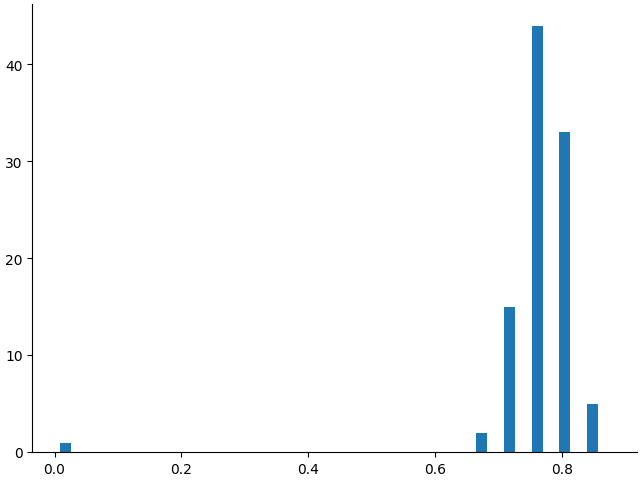

In [43]:
plt.hist([l_change[-1,:150], l_change[-1,150:]], bins=20);

(array([ 1,  2,  3, 16]), array([2, 4]))

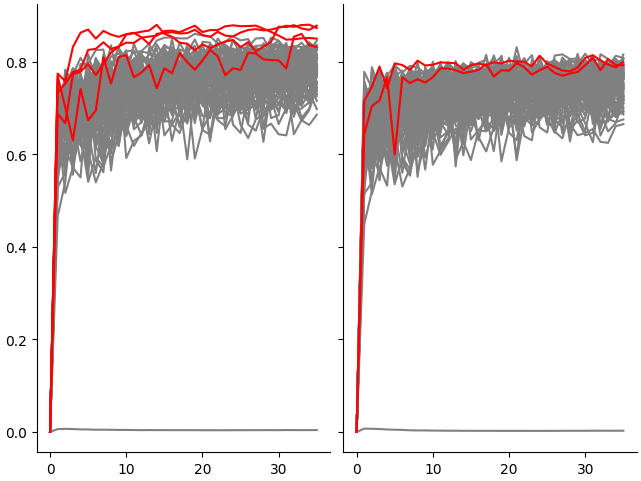

In [44]:
fig, ax = plt.subplots(1, 2, sharey='all')
ax[0].plot(l_change[:,il_nonland], c='grey');
ax[0].plot(l_change[:,il_landscape], c='r');
ax[1].plot(r_change[:,ir_nonland], c='grey');
ax[1].plot(r_change[:,ir_landscape], c='r');
il_landscape, ir_landscape

(array([ 1,  2,  3,  4,  5, 17, 19]),
 array([ 22,  25,  31,  32,  38,  40,  41,  42,  43,  44,  45,  46,  47,
         48,  49,  50,  51,  52,  53,  54,  55,  56,  60,  62,  65,  66,
         67,  68,  69,  70,  72,  79,  81,  82,  83,  84,  85,  86,  87,
         89,  90,  91,  92,  94,  96, 102, 103, 104, 105, 109, 125, 127,
        128, 137, 139, 141, 144, 145, 146, 147, 151, 152, 155, 170]))

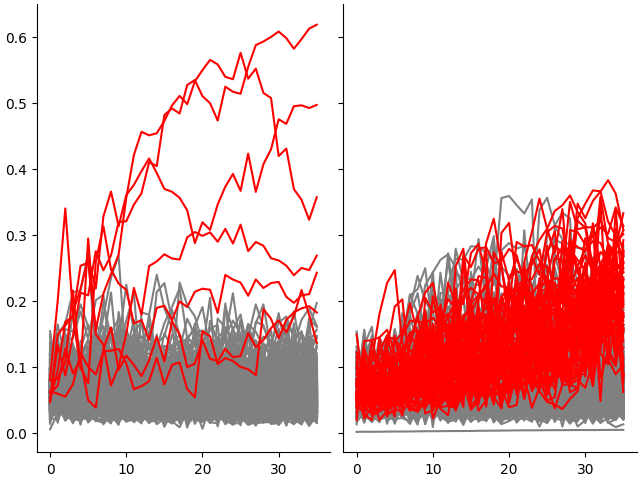

In [45]:
fig, ax = plt.subplots(1, 2, sharey='all')
ax[0].plot(l_mem_enc[:,il_nonmem], c='grey');
ax[0].plot(l_mem_enc[:,il_memory], c='r');
ax[1].plot(r_mem_enc[:,ir_nonmem], c='grey');
ax[1].plot(r_mem_enc[:,ir_memory], c='r');
il_memory, ir_memory

In [46]:
# idx_disrupt = il_memory
# idx_disrupt = il_landscape
J_disrupts = []
for idx_disrupt in (rng.choice([i for i in range(150, 200) if i not in il_memory], replace=False, size=10), il_memory):
    idx_replace = rng.choice(list(range(NE,NE+NI)), replace=False, size=len(idx_disrupt))
    print(idx_disrupt, idx_replace)
    # U, V = np.zeros((NE+NI,len(idx_disrupt))), np.zeros((len(idx_disrupt),NE+NI))
    U, V = svds[-1][0].copy(), svds[-1][2].copy()
    U[:,idx_disrupt], V[idx_disrupt] = svds[-1][0][:,idx_replace], svds[-1][2][idx_replace]
    U[:,idx_replace], V[idx_replace] = svds[-1][0][:,idx_disrupt], svds[-1][2][idx_disrupt]
    J_disrupt = U @ np.diag(svds[-1][1]) @ V
    # idx = [i for i in range(NE+NI) if i not in idx_disrupt]
    # J_disrupt = svds[-1][0][:,idx] @ np.diag(svds[-1][1][idx]) @ svds[-1][2][idx,:]
    # for i, j in enumerate(idx_disrupt):
    #     idxE, idxI = np.arange(NE), np.arange(NI)
    #     rng.shuffle(idxE)
    #     rng.shuffle(idxI)
    #     idx = np.concat([idxE, idxI+NE])
    #     U[:,i], V[i,:] = svds[-1][0][idx,j], svds[-1][2][j,idx]
        
    # aux = U @ np.diag(svds[-1][1][idx_disrupt]) @ V
    # J_disrupt += aux
    J_disrupts.append(J_disrupt)

[163 188 156 192 173 199 157 197 181 178] [748 633 627 616 713 649 659 607 638 669]
[ 1  2  3  4  5 17 19] [715 719 675 739 638 690 716]


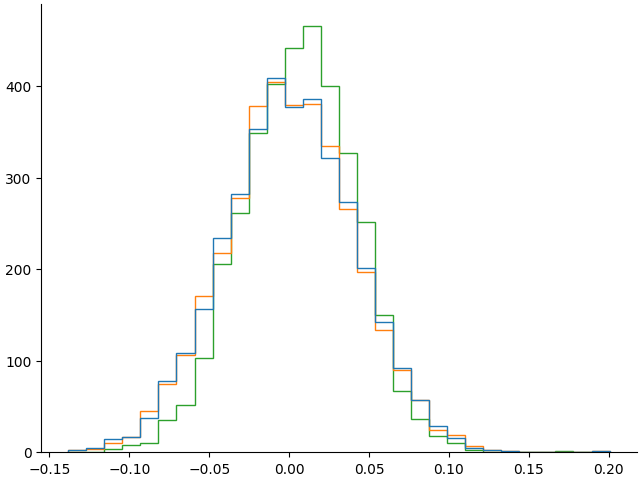

In [47]:
plt.hist([correlation(Js[-1][:NE,:NE].T, syl).flatten(),
          correlation(J_disrupts[0][:NE,:NE].T, syl).flatten(), 
          correlation(J_disrupts[1][:NE,:NE].T, syl).flatten()], 
# plt.hist([correlation(-Js[-1][:NE,NE:].T, syl).flatten(),
#           correlation(np.clip(-J_disrupts[0][:NE,NE:].T, 0, None), syl).flatten(), 
#           correlation(np.clip(-J_disrupts[1][:NE,NE:].T, 0, None), syl).flatten()], 
         histtype='step', alpha=1);

[Text(0, 0.5, 'presyn. neuron index'), Text(0.5, 0, 'Time (ms)')]

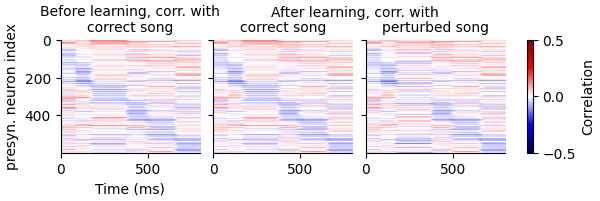

In [48]:
fig, ax = plot_corr_mat([J_disrupts[0][:NE,:NE], Js[-1][:NE,:NE]], 
                        sortby='min', vmin=-0.5, vmax=0.5)
# fig, ax = plot_corr_mat([-J_disrupts[0][:NE,NE:], -Js[-1][:NE,NE:]], 
#                         sortby='max', vmin=-0.5, vmax=0.5)
ax[0].set(ylabel='presyn. neuron index', xlabel='Time (ms)')